In [51]:
# Core libraries
import pandas as pd
import numpy as np

# Text preprocessing
import re
import string

# NLP tools
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# LLM support (OpenAI)
import openai


In [71]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/anachkhaidze/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anachkhaidze/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [72]:
# Adjust this path if the file is elsewhere
file_path = "data/metaphorValence.csv"
df = pd.read_csv(file_path)

# Preview your data
df.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,language#1_3_2,language#1_3_3,language#1_4_1,language#1_4_2,language#1_4_3,language#1_5_1,language#1_5_2,language#1_5_3,Q36,random
0,11/10/21 15:58,11/10/21 16:03,IP Address,65.184.69.197,100,322,True,11/10/21 16:03,R_3lVJS9mk7o2Togh,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States,652490
1,11/10/21 14:28,11/10/21 14:33,IP Address,108.34.215.20,100,323,True,11/10/21 14:33,R_2do9qyItqku7Nn3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U.S.,634128
2,11/10/21 15:00,11/10/21 15:08,IP Address,198.14.21.54,100,501,True,11/10/21 15:08,R_3g106D74dycqvVm,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"connecticut, alaska, california",586913
3,11/10/21 16:51,11/10/21 16:54,IP Address,74.136.120.181,100,127,True,11/10/21 16:54,R_2xKIsTBgAkyH5vD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,USA,202736
4,11/10/21 15:12,11/10/21 15:14,IP Address,205.133.127.242,100,74,True,11/10/21 15:14,R_2zuywXmfYnpQC4n,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States,541631


In [73]:
columns_to_drop = [
    "Status", "RecordedDate", "RecipientLastName", "RecipientFirstName",
    "RecipientEmail", "ExternalReference", "DistributionChannel", "UserLanguage", "consent", "Finished",
    "language.1_3_1", "language.1_3_3", "language.1_3_2", "language.1_4_1", "language.1_4_2", "language.1_4_3",
    "language.1_5_1", "language.1_5_2", "language.1_5_3", "random", "immigrationStatus_5_TEXT", 
    "immigrationStatus_5", "immigrationStatus_3", "immigrationStatus_4", "immigrationStatus_6",
    "immigrationStatus_8", "immigrationStatus_2", "language.1_2_1", "language.1_2_2", "language.1_2_3",
    "language.1_1_3", "politicalView_4_TEXT", "previousParticipatio", "gender_3_TEXT", "Progress",
    "StartDate", "EndDate", "IPAddress", "Duration..in.seconds.", "immigrationStatus_1"
]

df.drop(columns=columns_to_drop, inplace=True, errors="ignore")

In [74]:
print(df["valence"].value_counts())

valence
positive    685
negative    167
neutral      29
mixed        25
Name: count, dtype: int64


In [75]:
# Explicitly convert again to be sure
df["condition"] = df["condition"].astype("category")
df["gender"] = df["gender"].astype("category")
df["politicalView"] = df["politicalView"].astype("category")
df["valence"] = df["valence"].astype("category")

# Drop rows with NA or string "NA" in valence
df = df[~df["valence"].isin(["NA", "mixed"]) & df["valence"].notna()]

# Drop rows with 'Other' politicalView or gender
df = df[df["politicalView"] != "Other"]
df = df[df["gender"] != "Other"]

# # Drop rows where valence is 'mixed' or 'neutral'
# df = df[~df["valence"].isin(["mixed", "neutral"])]

# Drop unused categories
df["condition"] = df["condition"].cat.remove_unused_categories()
df["gender"] = df["gender"].cat.remove_unused_categories()
df["politicalView"] = df["politicalView"].cat.remove_unused_categories()
df["valence"] = df["valence"].cat.remove_unused_categories()

In [76]:
print(df["valence"].value_counts())

valence
positive    680
negative    167
neutral      28
Name: count, dtype: int64


In [77]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download the VADER lexicon (only needed once)
nltk.download('vader_lexicon')

# Drop NA and blank openQ responses
df = df[df["openQ"].notna()]
df = df[df["openQ"].str.strip().astype(bool)]

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis
df["vader_score"] = df["openQ"].apply(lambda x: sia.polarity_scores(x)["compound"])

# Classify the sentiment
def classify_sentiment(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

df["sentiment_llm"] = df["vader_score"].apply(classify_sentiment)

# View the result
df[["ResponseId", "openQ", "vader_score", "sentiment_llm"]].head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/anachkhaidze/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,ResponseId,openQ,vader_score,sentiment_llm
0,R_3lVJS9mk7o2Togh,Immigration has helped Addison economically. ...,-0.4939,negative
10,R_u4vXBZWJx0MujXb,all of the low skill manual labor jobs have be...,-0.2732,negative
11,R_3NFnPVLfLTttU2f,Alot of cheap labor is available. Probably mo...,0.0000,neutral
12,R_5i1uPLRQdNyZqUx,Cheap labor has come in. It has taken away loc...,0.0000,neutral
13,R_rpyVWpkMjI2yTSN,Flood has led to the change of economy. If the...,-0.5849,negative


In [78]:
df_compare = df[df["valence"].isin(["positive", "negative"])].copy()
pd.crosstab(df_check["valence"], df_check["sentiment_llm"], dropna=False)

sentiment_llm,negative,neutral,positive
valence,,,
negative,78,31,58
neutral,1,10,17
positive,21,72,587


In [79]:
from sklearn.metrics import classification_report

# Use only rows where valence != 'neutral' and sentiment_llm != 'neutral'
df_binary = df[
    (df["valence"].isin(["positive", "negative"])) &
    (df["sentiment_llm"].isin(["positive", "negative"]))
]

print(classification_report(df_binary["valence"], df_binary["sentiment_llm"]))

              precision    recall  f1-score   support

    negative       0.79      0.57      0.66       136
    positive       0.91      0.97      0.94       608

    accuracy                           0.89       744
   macro avg       0.85      0.77      0.80       744
weighted avg       0.89      0.89      0.89       744



In [99]:
df_reg = df[["likert", "vader_score", "positive"]].dropna()

In [100]:
from sklearn.linear_model import LinearRegression

# Reshape for sklearn (X must be 2D)
X = df_reg["vader_score"].values.reshape(-1, 1)
y = df_reg["likert"].values

model = LinearRegression()
model.fit(X, y)
print(f"Intercept: {model.intercept_:.3f}")
print(f"Slope: {model.coef_[0]:.3f}")
from sklearn.metrics import r2_score

y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
print(f"R-squared: {r2:.3f}")

Intercept: 6.336
Slope: 2.972
R-squared: 0.278


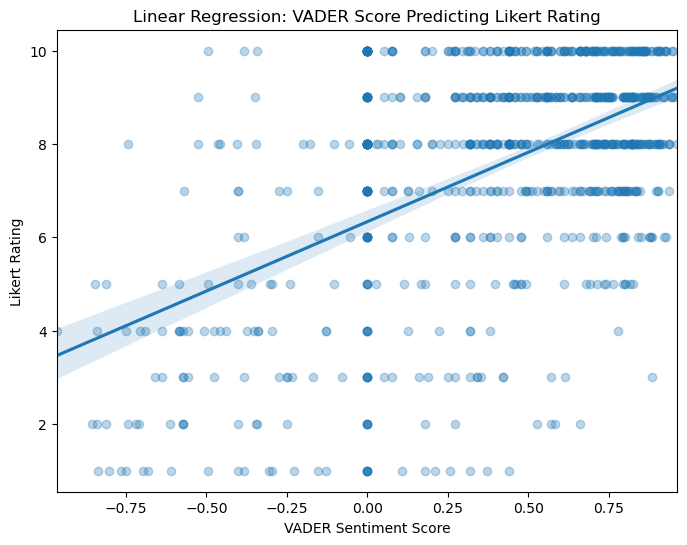

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.regplot(x="vader_score", y="likert", data=df_reg, scatter_kws={"alpha":0.3})
plt.title("Linear Regression: VADER Score Predicting Likert Rating")
plt.xlabel("VADER Sentiment Score")
plt.ylabel("Likert Rating")
plt.show()


In [102]:
from sklearn.linear_model import LinearRegression

# Reshape for sklearn (X must be 2D)
X = df_reg["positive"].values.reshape(-1, 1)
y = df_reg["likert"].values

model = LinearRegression()
model.fit(X, y)
print(f"Intercept: {model.intercept_:.3f}")
print(f"Slope: {model.coef_[0]:.3f}")
from sklearn.metrics import r2_score

y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
print(f"R-squared: {r2:.3f}")

Intercept: 4.460
Slope: 4.808
R-squared: 0.491


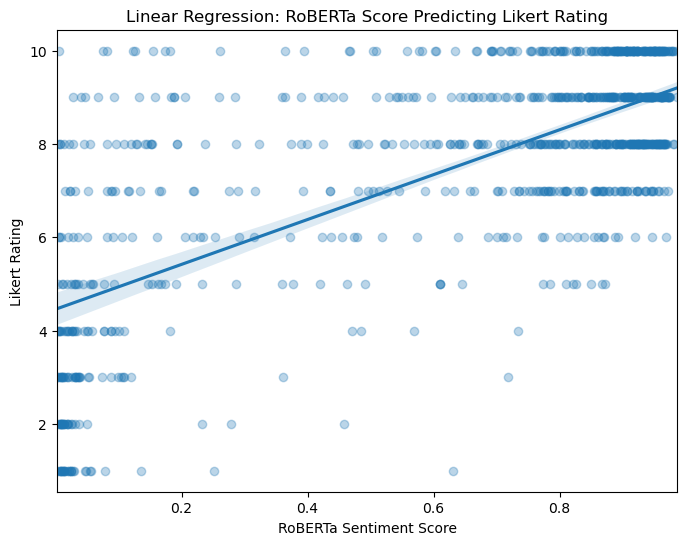

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.regplot(x="positive", y="likert", data=df_reg, scatter_kws={"alpha":0.3})
plt.title("Linear Regression: RoBERTa Score Predicting Likert Rating")
plt.xlabel("RoBERTa Sentiment Score")
plt.ylabel("Likert Rating")
plt.show()

In [83]:
df["condition"] = pd.Categorical(df["condition"], categories=["increase", "boost", "flood", "invasion"], ordered=True)
df["politicalView"] = pd.Categorical(df["politicalView"], categories=["Republican", "Independent", "Democrat"], ordered=True)

In [84]:
import statsmodels.formula.api as smf

model = smf.ols("vader_score ~ C(condition) * C(politicalView) ", data=df).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:            vader_score   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     4.387
Date:                Wed, 02 Apr 2025   Prob (F-statistic):           1.98e-06
Time:                        21:56:38   Log-Likelihood:                -468.14
No. Observations:                 875   AIC:                             960.3
Df Residuals:                     863   BIC:                             1018.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [85]:
from scipy.stats import zscore

df["vader_z"] = zscore(df["vader_score"], nan_policy='omit')
df["likert_z"] = zscore(df["likert"], nan_policy='omit')

In [119]:
vader_summary = (
    df
    .groupby(["condition", "politicalView"], as_index=False)
    .agg(
        n=("vader_z", lambda x: x.notna().sum()),
        mean_z=("vader_z", "mean"),
        sd_z=("vader_z", "std")
    )
)
vader_summary["se"] = vader_summary["sd_z"] / np.sqrt(vader_summary["n"])
vader_summary["ci_low"] = vader_summary["mean_z"] - 1.96 * vader_summary["se"]
vader_summary["ci_high"] = vader_summary["mean_z"] + 1.96 * vader_summary["se"]

likert_summary = (
    df
    .groupby(["condition", "politicalView"], as_index=False)
    .agg(
        n=("likert_z", lambda x: x.notna().sum()),
        mean_z=("likert_z", "mean"),
        sd_z=("likert_z", "std")
    )
)
likert_summary["se"] = likert_summary["sd_z"] / np.sqrt(likert_summary["n"])
likert_summary["ci_low"] = likert_summary["mean_z"] - 1.96 * likert_summary["se"]
likert_summary["ci_high"] = likert_summary["mean_z"] + 1.96 * likert_summary["se"]

/var/folders/4_/n1p8tswd39b0jr38l2pdhr4r0000gn/T/ipykernel_76874/3568613556.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["condition", "politicalView"], as_index=False)
/var/folders/4_/n1p8tswd39b0jr38l2pdhr4r0000gn/T/ipykernel_76874/3568613556.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["condition", "politicalView"], as_index=False)


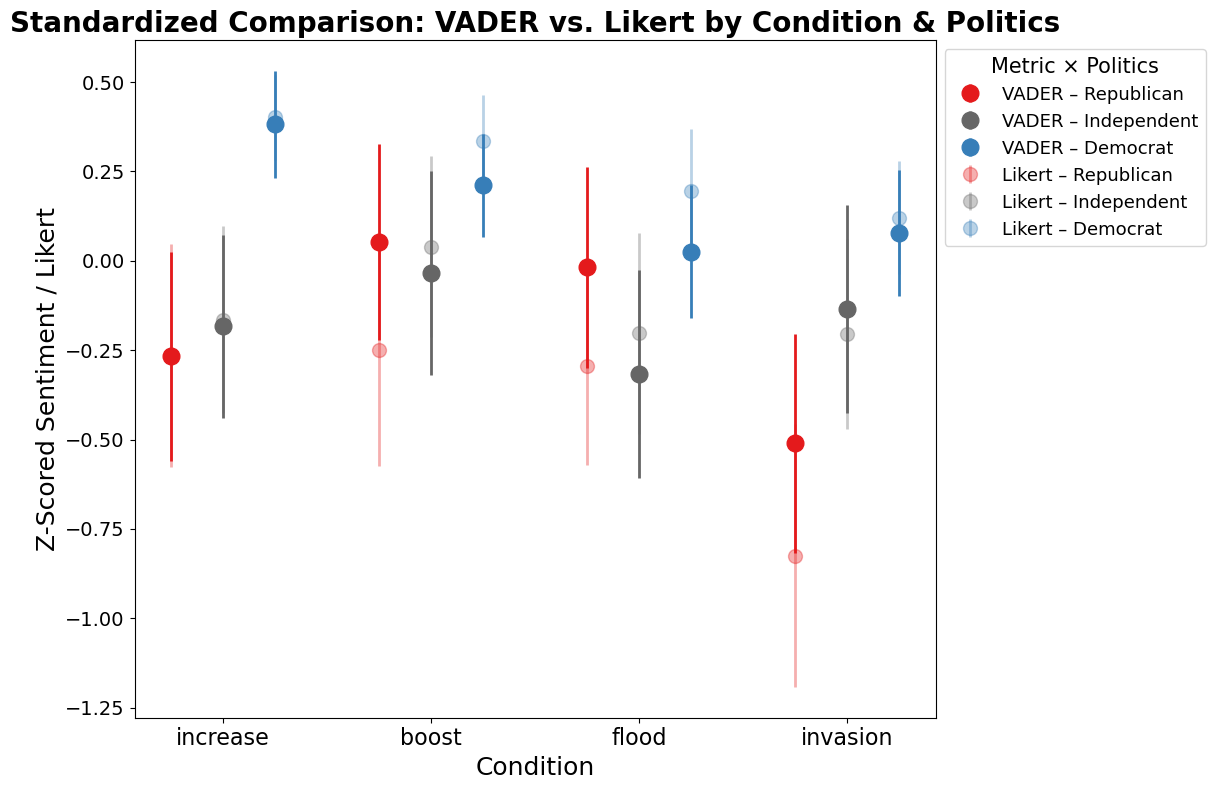

In [120]:
import matplotlib.pyplot as plt
import numpy as np

# Order
conditions = ["increase", "boost", "flood", "invasion"]
politicalView = ["Republican", "Independent", "Democrat"]
palette = {
    "Democrat": "#377eb8",
    "Republican": "#e41a1c",
    "Independent": "#666666"
}

x = np.arange(len(conditions))
width = 0.25  # separation between political groups

plt.figure(figsize=(12, 8))

# --- Plot VADER (z-scored)
for i, party in enumerate(politicalView):
    group = vader_summary[vader_summary["politicalView"] == party]
    x_pos = x + (i - 1) * width
    plt.errorbar(
        x=x_pos,
        y=group["mean_z"],                     
        yerr=1.96 * group["se"],
        fmt='o',
        label=f"VADER – {party}",
        color=palette[party],
        capsize=0,
        markersize=12,
        linewidth=2,
        alpha=1.0
    )

# --- Plot Likert (z-scored, transparent)
for i, party in enumerate(politicalView):
    group = likert_summary[likert_summary["politicalView"] == party]
    x_pos = x + (i - 1) * width
    plt.errorbar(
        x=x_pos,
        y=group["mean_z"],                    
        yerr=1.96 * group["se"],
        fmt='o',
        label=f"Likert – {party}",
        color=palette[party],
        capsize=0,
        markersize=10,
        linewidth=2,
        alpha=0.35                             
    )

# Formatting
plt.xticks(ticks=x, labels=conditions, fontsize=16)
plt.yticks(fontsize=14)
plt.xlabel("Condition", fontsize=18)
plt.ylabel("Z-Scored Sentiment / Likert", fontsize=18)
plt.title("Standardized Comparison: VADER vs. Likert by Condition & Politics", fontsize=20, weight='bold')
plt.legend(title="Metric × Politics", fontsize=13, title_fontsize=15, loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(False)
plt.tight_layout()
plt.show()

In [121]:
from textblob import TextBlob

df["textblob_polarity"] = df["openQ"].apply(lambda x: TextBlob(x).sentiment.polarity)

In [122]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch

# Reload tokenizer and model
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
roberta_model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [123]:
def roberta_sentiment(text):
    if not isinstance(text, str) or not text.strip():
        return None
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True)
    with torch.no_grad():
        output = roberta_model(**encoded_input)
    scores = softmax(output.logits.numpy()[0])
    labels = ['negative', 'neutral', 'positive']
    return dict(zip(labels, scores))

In [124]:
# 1. Identify valid rows
valid_rows = df["openQ"].notna() & df["openQ"].str.strip().astype(bool)

# 2. Apply your existing roberta_sentiment function
roberta_scores = df.loc[valid_rows, "openQ"].apply(roberta_sentiment)

# 3. Create a DataFrame of the sentiment scores
roberta_df = pd.DataFrame(list(roberta_scores), index=df.loc[valid_rows].index)

# 4. Add columns to the original df without changing its shape
df[["negative", "neutral", "positive"]] = roberta_df

# 5. Assign the label with the highest probability
df["roberta_sentiment"] = df[["negative", "neutral", "positive"]].idxmax(axis=1)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [126]:
from scipy.stats import pearsonr

# Drop rows with missing likert or positive score
mask = df["likert"].notna() & df["positive"].notna()
corr, pval = pearsonr(df.loc[mask, "positive"], df.loc[mask, "likert"])

print(f"Correlation (RoBERTa positive vs. Likert): r = {corr:.3f}, p = {pval:.4f}")


Correlation (RoBERTa positive vs. Likert): r = 0.701, p = 0.0000


In [127]:
from sklearn.metrics import classification_report, confusion_matrix

# Filter to rows where both are non-null and in {positive, negative}
mask = df["valence"].isin(["positive", "negative"]) & df["roberta_sentiment"].isin(["positive", "negative"])

print(confusion_matrix(df.loc[mask, "valence"], df.loc[mask, "roberta_sentiment"]))
print(classification_report(df.loc[mask, "valence"], df.loc[mask, "roberta_sentiment"]))

[[113  11]
 [  4 612]]
              precision    recall  f1-score   support

    negative       0.97      0.91      0.94       124
    positive       0.98      0.99      0.99       616

    accuracy                           0.98       740
   macro avg       0.97      0.95      0.96       740
weighted avg       0.98      0.98      0.98       740



In [128]:
df["condition"] = pd.Categorical(df["condition"], categories=["increase", "boost", "flood", "invasion"], ordered=True)
df["politicalView"] = pd.Categorical(df["politicalView"], categories=["Republican", "Independent", "Democrat"], ordered=True)
df["roberta_sentiment"] = df["roberta_sentiment"].astype("category")

df_bin = df[df["roberta_sentiment"].isin(["positive", "negative"])].copy()
df_bin["roberta_bin"] = df_bin["roberta_sentiment"].map({"negative": 0, "positive": 1})

In [129]:
import statsmodels.formula.api as smf

model = smf.logit("roberta_bin ~ C(condition) * C(politicalView)", data=df_bin).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.407407
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            roberta_bin   No. Observations:                  745
Model:                          Logit   Df Residuals:                      733
Method:                           MLE   Df Model:                           11
Date:                Wed, 02 Apr 2025   Pseudo R-squ.:                 0.07711
Time:                        22:35:53   Log-Likelihood:                -303.52
converged:                       True   LL-Null:                       -328.88
Covariance Type:            nonrobust   LLR p-value:                 4.647e-07
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept       

In [132]:
valence_summary = (
    df[df["valence"].isin(["positive", "negative"])]
    .groupby(["condition", "politicalView"], as_index=False)
    .agg(
        n=("valence", "count"),
        n_positive=("valence", lambda x: (x == "positive").sum())
    )
)

valence_summary["proportion_positive"] = valence_summary["n_positive"] / valence_summary["n"]
valence_summary["se"] = np.sqrt(valence_summary["proportion_positive"] * (1 - valence_summary["proportion_positive"]) / valence_summary["n"])
valence_summary["ci_low"] = valence_summary["proportion_positive"] - 1.96 * valence_summary["se"]
valence_summary["ci_high"] = valence_summary["proportion_positive"] + 1.96 * valence_summary["se"]

roberta_bin_summary = (
    df[df["roberta_sentiment"].isin(["positive", "negative"])]
    .groupby(["condition", "politicalView"], as_index=False)
    .agg(
        n=("roberta_sentiment", "count"),
        n_positive=("roberta_sentiment", lambda x: (x == "positive").sum())
    )
)

roberta_bin_summary["proportion_positive"] = roberta_bin_summary["n_positive"] / roberta_bin_summary["n"]
roberta_bin_summary["se"] = np.sqrt(roberta_bin_summary["proportion_positive"] * (1 - roberta_bin_summary["proportion_positive"]) / roberta_bin_summary["n"])
roberta_bin_summary["ci_low"] = roberta_bin_summary["proportion_positive"] - 1.96 * roberta_bin_summary["se"]
roberta_bin_summary["ci_high"] = roberta_bin_summary["proportion_positive"] + 1.96 * roberta_bin_summary["se"]

/var/folders/4_/n1p8tswd39b0jr38l2pdhr4r0000gn/T/ipykernel_76874/268007633.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["condition", "politicalView"], as_index=False)
/var/folders/4_/n1p8tswd39b0jr38l2pdhr4r0000gn/T/ipykernel_76874/268007633.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["condition", "politicalView"], as_index=False)


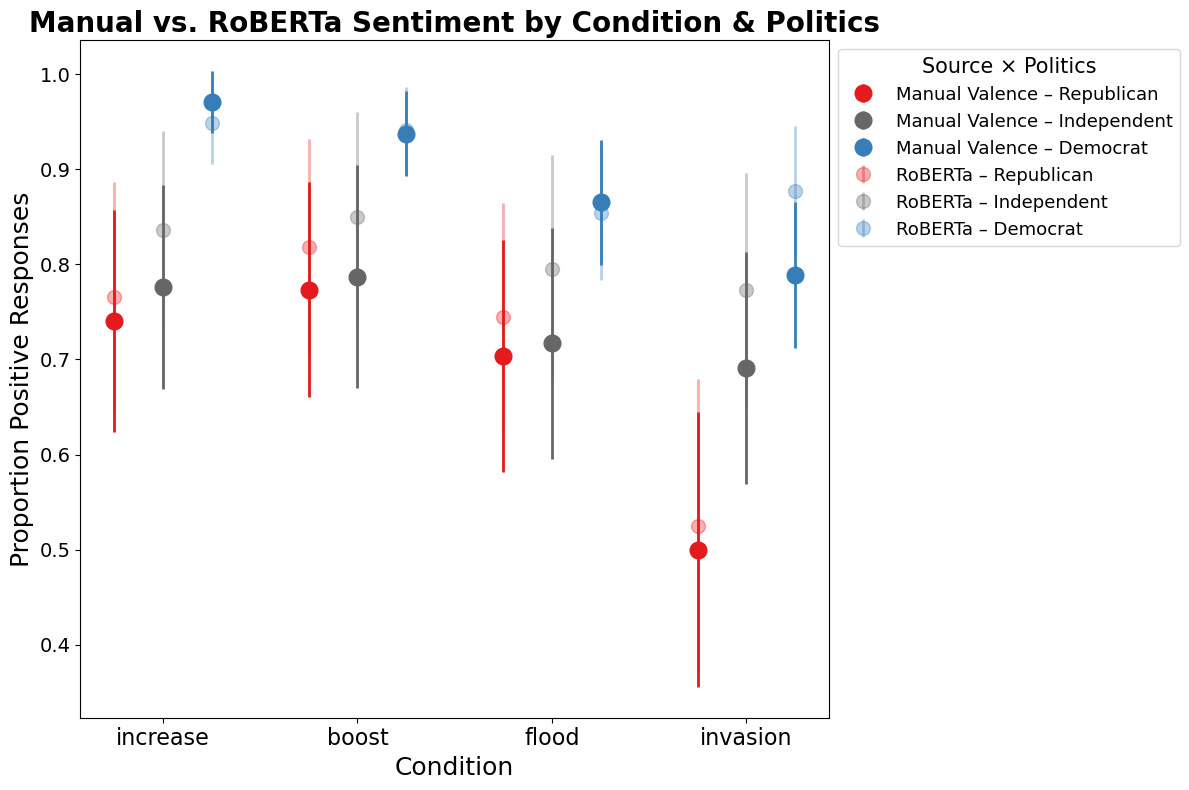

In [135]:
plt.figure(figsize=(12, 8))

# Plot manually coded valence (primary)
for i, party in enumerate(politicalView):
    group = valence_summary[valence_summary["politicalView"] == party]
    x_pos = x + (i - 1) * width
    plt.errorbar(
        x=x_pos,
        y=group["proportion_positive"],  # ✅ updated
        yerr=1.96 * group["se"],
        fmt='o',
        label=f"Manual Valence – {party}",
        color=palette[party],
        capsize=0,
        markersize=12,
        linewidth=2,
        alpha=1.0
    )

# Plot RoBERTa sentiment (transparent overlay)
for i, party in enumerate(politicalView):
    group = roberta_bin_summary[roberta_bin_summary["politicalView"] == party]
    x_pos = x + (i - 1) * width
    plt.errorbar(
        x=x_pos,
        y=group["proportion_positive"],  # ✅ updated
        yerr=1.96 * group["se"],
        fmt='o',
        label=f"RoBERTa – {party}",
        color=palette[party],
        capsize=0,
        markersize=10,
        linewidth=2,
        alpha=0.35
    )

# Formatting
plt.xticks(ticks=x, labels=conditions, fontsize=16)
plt.yticks(fontsize=14)
plt.xlabel("Condition", fontsize=18)
plt.ylabel("Proportion Positive Responses", fontsize=18)  # ✅ updated
plt.title("Manual vs. RoBERTa Sentiment by Condition & Politics", fontsize=20, weight='bold')
plt.legend(title="Source × Politics", fontsize=13, title_fontsize=15, loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(False)
plt.tight_layout()
plt.show()

In [136]:
df["positive_z"] = zscore(df["positive"].dropna(), nan_policy="omit")


In [139]:
likert_z_summary = (
    df
    .groupby(["condition", "politicalView"], as_index=False)
    .agg(
        n=("likert_z", lambda x: x.notna().sum()),
        mean_z=("likert_z", "mean"),
        sd_z=("likert_z", "std")
    )
)
likert_z_summary["se"] = likert_z_summary["sd_z"] / np.sqrt(likert_z_summary["n"])
likert_z_summary["ci_low"] = likert_z_summary["mean_z"] - 1.96 * likert_z_summary["se"]
likert_z_summary["ci_high"] = likert_z_summary["mean_z"] + 1.96 * likert_z_summary["se"]

positive_z_summary = (
    df
    .groupby(["condition", "politicalView"], as_index=False)
    .agg(
        n=("positive_z", lambda x: x.notna().sum()),
        mean_z=("positive_z", "mean"),
        sd_z=("positive_z", "std")
    )
)
positive_z_summary["se"] = positive_z_summary["sd_z"] / np.sqrt(positive_z_summary["n"])
positive_z_summary["ci_low"] = positive_z_summary["mean_z"] - 1.96 * positive_z_summary["se"]
positive_z_summary["ci_high"] = positive_z_summary["mean_z"] + 1.96 * positive_z_summary["se"]

/var/folders/4_/n1p8tswd39b0jr38l2pdhr4r0000gn/T/ipykernel_76874/3948427037.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["condition", "politicalView"], as_index=False)
/var/folders/4_/n1p8tswd39b0jr38l2pdhr4r0000gn/T/ipykernel_76874/3948427037.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["condition", "politicalView"], as_index=False)


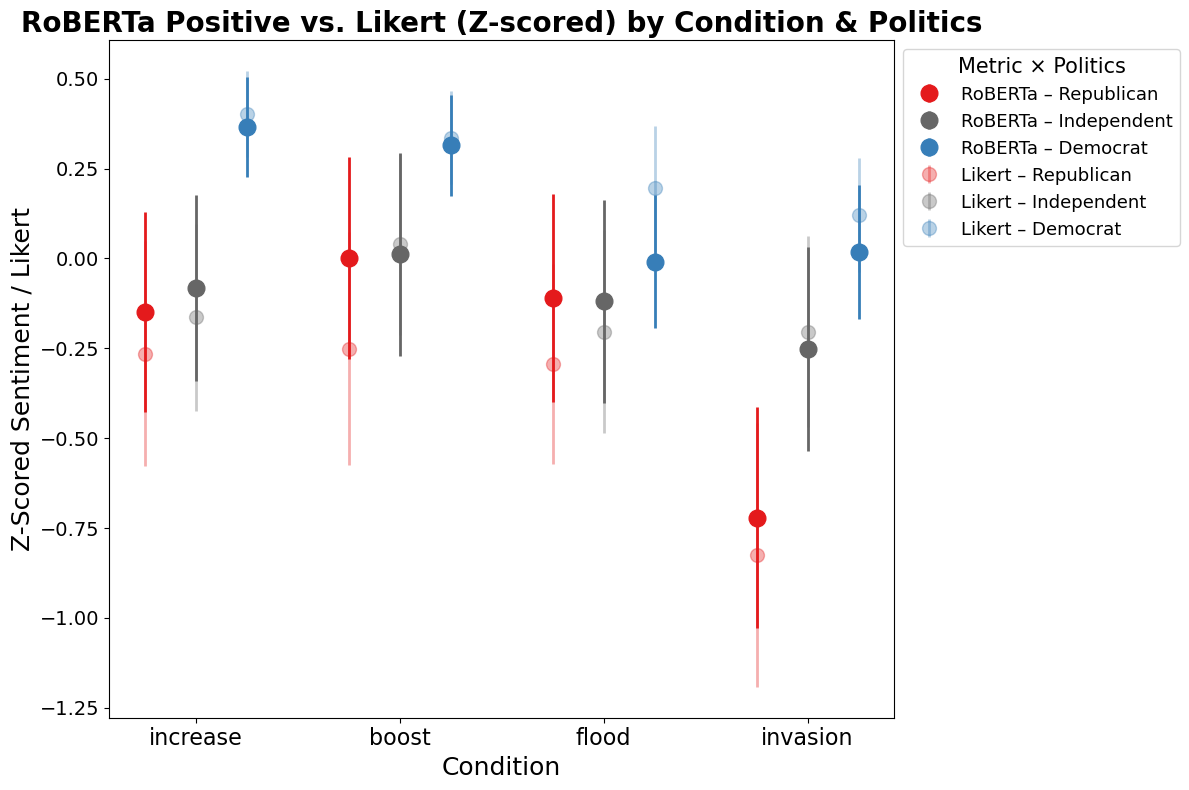

In [140]:
plt.figure(figsize=(12, 8))

# Plot RoBERTa (main line)
for i, party in enumerate(politicalView):
    group = positive_z_summary[positive_z_summary["politicalView"] == party]
    x_pos = x + (i - 1) * width
    plt.errorbar(
        x=x_pos,
        y=group["mean_z"],
        yerr=1.96 * group["se"],
        fmt='o',
        label=f"RoBERTa – {party}",
        color=palette[party],
        capsize=0,
        markersize=12,
        linewidth=2,
        alpha=1.0
    )

# Plot Likert (transparent overlay)
for i, party in enumerate(politicalView):
    group = likert_z_summary[likert_z_summary["politicalView"] == party]
    x_pos = x + (i - 1) * width
    plt.errorbar(
        x=x_pos,
        y=group["mean_z"],
        yerr=1.96 * group["se"],
        fmt='o',
        label=f"Likert – {party}",
        color=palette[party],
        capsize=0,
        markersize=10,
        linewidth=2,
        alpha=0.35
    )

# Labels & formatting
plt.xticks(ticks=x, labels=conditions, fontsize=16)
plt.yticks(fontsize=14)
plt.xlabel("Condition", fontsize=18)
plt.ylabel("Z-Scored Sentiment / Likert", fontsize=18)
plt.title("RoBERTa Positive vs. Likert (Z-scored) by Condition & Politics", fontsize=20, weight='bold')
plt.legend(title="Metric × Politics", fontsize=13, title_fontsize=15, loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(False)
plt.tight_layout()
plt.show()


In [141]:
valid_paraphrase = df["paraphrase"].notna() & df["paraphrase"].str.strip().astype(bool)
paraphrase_scores = df.loc[valid_paraphrase, "paraphrase"].apply(roberta_sentiment)
paraphrase_df = pd.DataFrame(list(paraphrase_scores), index=df.loc[valid_paraphrase].index)
df[["paraphrase_negative", "paraphrase_neutral", "paraphrase_positive"]] = paraphrase_df
df["paraphrase_sentiment"] = df[
    ["paraphrase_negative", "paraphrase_neutral", "paraphrase_positive"]
].idxmax(axis=1).str.replace("paraphrase_", "")

In [142]:
model = smf.ols("paraphrase_positive ~ C(condition) * C(politicalView)", data=df).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     paraphrase_positive   R-squared:                       0.043
Model:                             OLS   Adj. R-squared:                  0.031
Method:                  Least Squares   F-statistic:                     3.533
Date:                 Wed, 02 Apr 2025   Prob (F-statistic):           7.20e-05
Time:                         22:37:51   Log-Likelihood:                 241.28
No. Observations:                  875   AIC:                            -458.6
Df Residuals:                      863   BIC:                            -401.3
Df Model:                           11                                         
Covariance Type:             nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [154]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [155]:
model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
original_passage = "In the last three years, there has been a(n) [METAPHOR] of immigrant labor in the town of Addison. This change has affected the local economy in several ways..."

# Replace with neutral version
neutral_passage = original_passage.replace("[METAPHOR]", "increase")

# Embed original passage
original_embedding = model.encode(neutral_passage)


In [156]:
passage_templates = {
    "increase": """In the last three years, there has been an increase of immigrant labor in the town of Addison. Most of the immigrants do farm work in the surrounding agricultural communities. Some have expanded into construction, cleaning, food service, or other manual labor professions. Some immigrants have also started businesses, opening restaurants, or small shops. In 2016, there were 12,000 immigrants working in Addison, but that number has rapidly grown. In 2020, there were 40,000 immigrant workers.""",
    
    "boost": """In the last three years, there has been a boost of immigrant labor in the town of Addison. Most of the immigrants do farm work in the surrounding agricultural communities. Some have expanded into construction, cleaning, food service, or other manual labor professions. Some immigrants have also started businesses, opening restaurants, or small shops. In 2016, there were 12,000 immigrants working in Addison, but that number has rapidly grown. In 2020, there were 40,000 immigrant workers.""",
    
    "flood": """In the last three years, there has been a flood of immigrant labor in the town of Addison. Most of the immigrants do farm work in the surrounding agricultural communities. Some have expanded into construction, cleaning, food service, or other manual labor professions. Some immigrants have also started businesses, opening restaurants, or small shops. In 2016, there were 12,000 immigrants working in Addison, but that number has rapidly grown. In 2020, there were 40,000 immigrant workers.""",
    
    "invasion": """In the last three years, there has been an invasion of immigrant labor in the town of Addison. Most of the immigrants do farm work in the surrounding agricultural communities. Some have expanded into construction, cleaning, food service, or other manual labor professions. Some immigrants have also started businesses, opening restaurants, or small shops. In 2016, there were 12,000 immigrants working in Addison, but that number has rapidly grown. In 2020, there were 40,000 immigrant workers."""
}

In [157]:
# Prepare similarity scores
similarities = []

# Iterate through rows
for idx, row in df.iterrows():
    cond = row["condition"]
    paraphrase = row.get("paraphrase", "")
    
    if isinstance(paraphrase, str) and paraphrase.strip() and cond in passage_templates:
        passage_text = passage_templates[cond]
        embedding_passage = model.encode(passage_text)
        embedding_paraphrase = model.encode(paraphrase)
        
        # Compute cosine similarity
        sim = cosine_similarity([embedding_paraphrase], [embedding_passage])[0][0]
    else:
        sim = np.nan
    
    similarities.append(sim)

# Store in new column
df["paraphrase_similarity"] = similarities

In [159]:
import statsmodels.formula.api as smf

# Drop NA similarities
df_sim = df[df["paraphrase_similarity"].notna()].copy()

# Run linear model
similarity_model = smf.ols("paraphrase_similarity ~ C(condition) * C(politicalView)", data=df_sim).fit()

# Summary output
print(similarity_model.summary())

                              OLS Regression Results                             
Dep. Variable:     paraphrase_similarity   R-squared:                       0.028
Model:                               OLS   Adj. R-squared:                  0.015
Method:                    Least Squares   F-statistic:                     2.248
Date:                   Wed, 02 Apr 2025   Prob (F-statistic):             0.0108
Time:                           22:51:18   Log-Likelihood:                 588.01
No. Observations:                    875   AIC:                            -1152.
Df Residuals:                        863   BIC:                            -1095.
Df Model:                             11                                         
Covariance Type:               nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

In [160]:
import numpy as np

# Summary dataframe
similarity_summary = (
    df_sim
    .groupby(["condition", "politicalView"], as_index=False)
    .agg(
        n=("paraphrase_similarity", "count"),
        mean_similarity=("paraphrase_similarity", "mean"),
        sd_similarity=("paraphrase_similarity", "std")
    )
)

# Add standard error and 95% CI
similarity_summary["se"] = similarity_summary["sd_similarity"] / np.sqrt(similarity_summary["n"])
similarity_summary["ci_low"] = similarity_summary["mean_similarity"] - 1.96 * similarity_summary["se"]
similarity_summary["ci_high"] = similarity_summary["mean_similarity"] + 1.96 * similarity_summary["se"]


/var/folders/4_/n1p8tswd39b0jr38l2pdhr4r0000gn/T/ipykernel_76874/443503102.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["condition", "politicalView"], as_index=False)


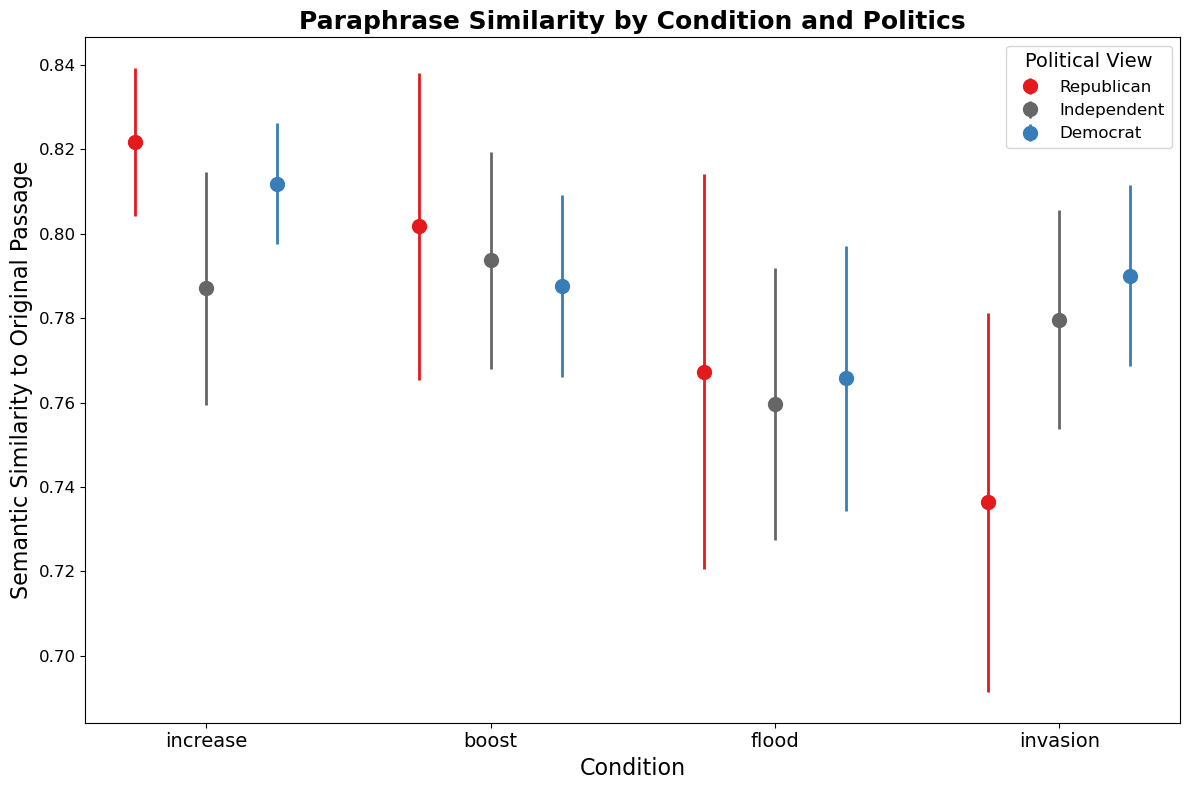

In [161]:
import matplotlib.pyplot as plt

# Plot setup
conditions = ["increase", "boost", "flood", "invasion"]
politics = ["Republican", "Independent", "Democrat"]
palette = {
    "Democrat": "#377eb8",
    "Republican": "#e41a1c",
    "Independent": "#666666"
}
x = np.arange(len(conditions))
width = 0.25

plt.figure(figsize=(12, 8))

# Plot error bars for each political group
for i, party in enumerate(politics):
    group = similarity_summary[similarity_summary["politicalView"] == party]
    x_pos = x + (i - 1) * width
    plt.errorbar(
        x=x_pos,
        y=group["mean_similarity"],
        yerr=1.96 * group["se"],
        fmt='o',
        label=party,
        color=palette[party],
        capsize=0,
        markersize=10,
        linewidth=2
    )

plt.xticks(ticks=x, labels=conditions, fontsize=14)
plt.yticks(fontsize=12)
plt.xlabel("Condition", fontsize=16)
plt.ylabel("Semantic Similarity to Original Passage", fontsize=16)
plt.title("Paraphrase Similarity by Condition and Politics", fontsize=18, weight='bold')
plt.legend(title="Political View", fontsize=12, title_fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.show()

**Metaphors like "invasion" not only bias how people evaluate immigration (as we knew) but also alter their memory of the facts.
This distortion is strongest among Republicans — suggesting they may be more susceptible to metaphoric framing, or that it activates ideologically congruent schemas (e.g., war-like threat framing).**

Do some metaphors distort recall more?

Does political alignment lead to closer/further paraphrasing?

In [262]:
import nltk
from nltk.corpus import wordnet as wn

# Download WordNet if not already done
nltk.download('wordnet')
nltk.download('omw-1.4')

# Function to expand a lexicon using WordNet
def expand_lexicon(lexicon):
    expanded = set(lexicon)
    for word in lexicon:
        for syn in wn.synsets(word):
            for lemma in syn.lemmas():
                lemma_clean = lemma.name().lower().replace('_', ' ')
                expanded.add(lemma_clean)
    return sorted(expanded)

# Original lexicons
war_lexicon = [
    "invasion", "invade", "invading", "attack", "attacked", "aggression", "aggressor",
    "enemy", "enemies", "threat", "threatening", "danger", "force", "control", "violence",
    "overwhelm", "overwhelming", "takeover", "conquer", "defense", "military", "security",
    "illegal", "border", "combat", "hostile", "conflict", "occupation", "breach", "resistance"
]

nature_lexicon = [
    "flood", "flooded", "wave", "waves", "surge", "overflow", "torrent", "swept", "submerge",
    "submerged", "inundate", "inundation", "tsunami", "natural", "waters", "disaster", "rising",
    "overwhelm", "storm", "deluge", "drown", "tide", "current", "crash", "drift", "erupt", "landslide"
]

growth_lexicon = [
    "boost", "growth", "opportunity", "development", "expand", "expansion",
    "contribution", "support", "investment", "success", "positive", "benefit", "create",
    "prosper", "build"
]

# Expand each lexicon
war_expanded = expand_lexicon(war_lexicon)
nature_expanded = expand_lexicon(nature_lexicon)
growth_expanded = expand_lexicon(growth_lexicon)

growth_expanded = set(growth_expanded) - {"increase"}

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/anachkhaidze/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/anachkhaidze/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [263]:
import re
from scipy.stats import zscore

# --- Tokenize and clean paraphrases ---
df["paraphrase_tokens"] = (
    df["paraphrase"].astype(str)
    .str.lower()
    .apply(lambda x: re.findall(r"\b\w+\b", x))
)

# --- Count lexicon matches ---
def count_matches(tokens, lexicon):
    return sum(1 for word in tokens if word in lexicon)

df["war_matches"] = df["paraphrase_tokens"].apply(lambda x: count_matches(x, war_expanded))
df["nature_matches"] = df["paraphrase_tokens"].apply(lambda x: count_matches(x, nature_expanded))
df["growth_matches"] = df["paraphrase_tokens"].apply(lambda x: count_matches(x, growth_expanded))

# --- Token length ---
df["n_tokens"] = df["paraphrase_tokens"].apply(len)

# --- Normalize: proportion per total words ---
df["prop_war"] = df["war_matches"] / df["n_tokens"]
df["prop_nature"] = df["nature_matches"] / df["n_tokens"]
df["prop_growth"] = df["growth_matches"] / df["n_tokens"]

# --- Standardize (z-score) across dataset ---
df["z_prop_war"] = zscore(df["prop_war"].fillna(0))
df["z_prop_nature"] = zscore(df["prop_nature"].fillna(0))
df["z_prop_growth"] = zscore(df["prop_growth"].fillna(0))

In [264]:
# STEP 1: Tokenize original passage (same for all participants)
original_passage = """
In the last three years, there has been a(n) {} of immigrant labor in the town of Addison. Most of the immigrants do farm work in the surrounding agricultural communities. Some have expanded into construction, cleaning, food service, or other manual labor professions. Some immigrants have also started businesses, opening restaurants, or small shops. In 2016, there were 12,000 immigrants working in Addison, but that number has rapidly grown. In 2020, there were 40,000 immigrant workers.
"""
import re

passage_tokens = set(re.findall(r'\b\w+\b', original_passage.lower()))
passage_tokens.add("increase")  # manually remove "increase" from paraphrase analysis
print(f"# unique passage words: {len(passage_tokens)}")

# STEP 2: Define helper function to count non-passage tokens
def non_passage_tokens(tokens):
    return [word for word in tokens if word not in passage_tokens]

# STEP 3: Apply to df
df["non_passage_tokens"] = df["paraphrase_tokens"].apply(non_passage_tokens)
df["n_non_passage"] = df["non_passage_tokens"].apply(len)

# STEP 4: Count lexicon matches only among non-passage tokens
def count_matches_filtered(tokens, lexicon):
    return sum(1 for word in tokens if word in lexicon)

df["war_matches_filtered"] = df["non_passage_tokens"].apply(lambda x: count_matches_filtered(x, war_expanded))
df["nature_matches_filtered"] = df["non_passage_tokens"].apply(lambda x: count_matches_filtered(x, nature_expanded))
df["growth_matches_filtered"] = df["non_passage_tokens"].apply(lambda x: count_matches_filtered(x, growth_expanded))

# STEP 5: Normalize by number of non-passage words
df["prop_war_filtered"] = df["war_matches_filtered"] / df["n_non_passage"]
df["prop_nature_filtered"] = df["nature_matches_filtered"] / df["n_non_passage"]
df["prop_growth_filtered"] = df["growth_matches_filtered"] / df["n_non_passage"]

# unique passage words: 56


In [265]:
import numpy as np

summary_filtered = (
    df
    .groupby(["condition", "politicalView"], observed=True)
    .agg(
        n=("paraphrase", "count"),
        mean_war=("prop_war_filtered", "mean"),
        se_war=("prop_war_filtered", lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
        mean_nature=("prop_nature_filtered", "mean"),
        se_nature=("prop_nature_filtered", lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
        mean_growth=("prop_growth_filtered", "mean"),
        se_growth=("prop_growth_filtered", lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
    )
    .reset_index()
)

In [266]:
import numpy as np

summary_filtered_raw = (
    df
    .groupby(["condition", "politicalView"], observed=True)
    .agg(
        n=("paraphrase", "count"),
        mean_war=("war_matches_filtered", "mean"),
        se_war=("war_matches_filtered", lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
        mean_nature=("nature_matches_filtered", "mean"),
        se_nature=("nature_matches_filtered", lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
        mean_growth=("growth_matches_filtered", "mean"),
        se_growth=("growth_matches_filtered", lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
    )
    .reset_index()
)

In [267]:
summary_filtered

,condition,politicalView,n,mean_war,se_war,mean_nature,se_nature,mean_growth,se_growth
0,increase,Republican,55,0.008488,0.006492,0.002315,0.002294,0.030093,0.015680
1,increase,Independent,61,0.003279,0.003279,0.014208,0.008263,0.061085,0.022175
2,increase,Democrat,105,0.015686,0.007669,0.048529,0.014089,0.056481,0.013790
3,boost,Republican,53,0.002695,0.002695,0.039645,0.020769,0.084906,0.027447
4,boost,Independent,50,0.003333,0.003333,0.020000,0.012271,0.056333,0.017142
5,boost,Democrat,113,0.008702,0.003869,0.014635,0.005902,0.042199,0.016474
6,flood,Republican,56,0.009091,0.009009,0.058658,0.023314,0.014719,0.009730
7,flood,Independent,53,0.044872,0.027245,0.083974,0.034113,0.011218,0.007862
8,flood,Democrat,111,0.018298,0.009797,0.074430,0.018612,0.023191,0.011246
9,invasion,Republican,49,0.062964,0.024221,0.068707,0.030276,0.043197,0.023409


In [268]:
summary_filtered_raw

,condition,politicalView,n,mean_war,se_war,mean_nature,se_nature,mean_growth,se_growth
0,increase,Republican,55,0.036364,0.025474,0.018182,0.018182,0.072727,0.035339
1,increase,Independent,61,0.016393,0.016393,0.049180,0.027917,0.147541,0.045784
2,increase,Democrat,105,0.047619,0.020882,0.142857,0.034313,0.200000,0.041492
3,boost,Republican,53,0.018868,0.018868,0.113208,0.043939,0.188679,0.054257
4,boost,Independent,50,0.020000,0.020000,0.060000,0.033927,0.220000,0.065714
5,boost,Democrat,113,0.044248,0.019432,0.070796,0.027302,0.097345,0.030701
6,flood,Republican,56,0.017857,0.017857,0.142857,0.047184,0.053571,0.030362
7,flood,Independent,53,0.056604,0.032046,0.132075,0.046952,0.037736,0.026425
8,flood,Democrat,111,0.063063,0.023176,0.261261,0.070927,0.063063,0.023176
9,invasion,Republican,49,0.224490,0.066913,0.142857,0.050508,0.102041,0.043691


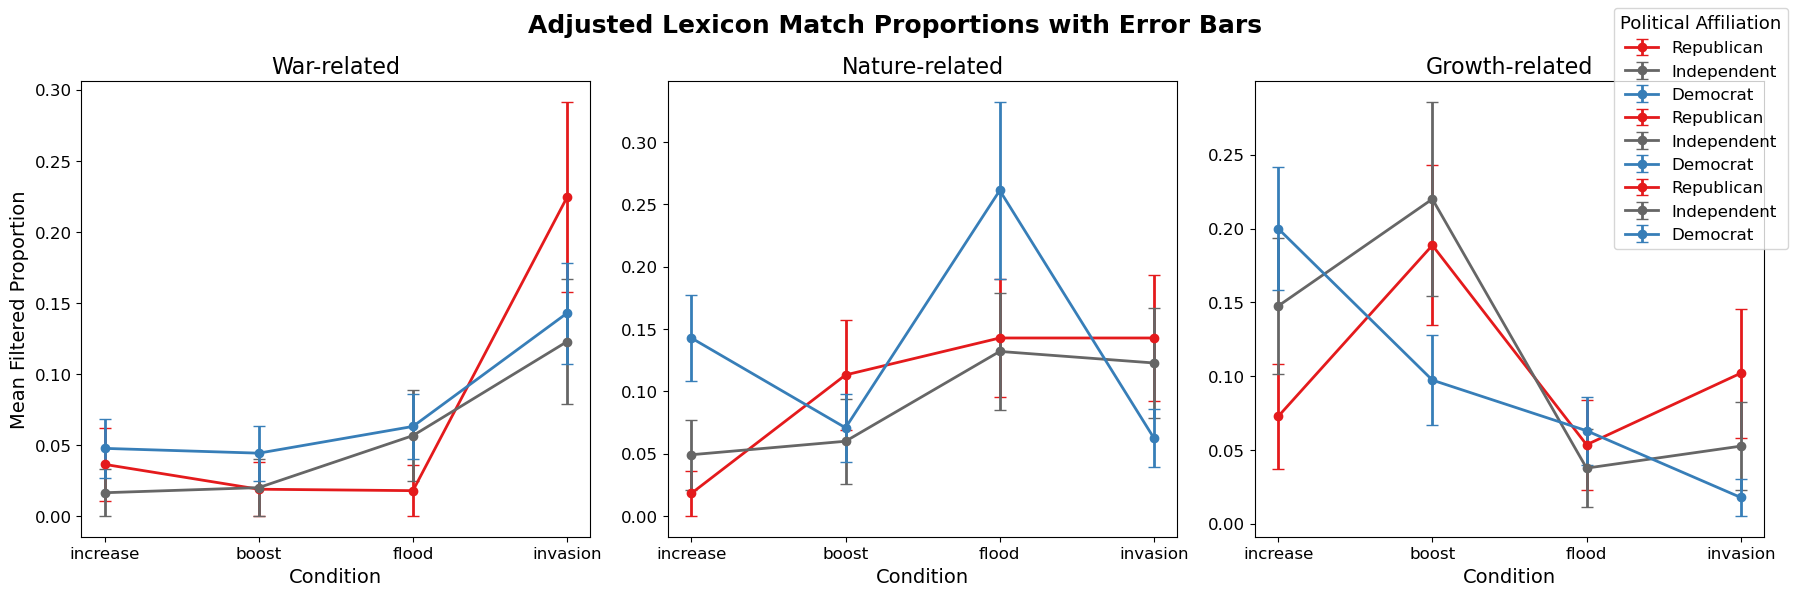

In [269]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

metrics = [
    ("mean_war", "se_war", "War-related"),
    ("mean_nature", "se_nature", "Nature-related"),
    ("mean_growth", "se_growth", "Growth-related")
]

for i, (mean_col, se_col, title) in enumerate(metrics):
    ax = axes[i]
    for party in politics:
        subset = summary_filtered_raw[summary_filtered_raw["politicalView"] == party]
        x = np.arange(len(conditions))
        means = [subset[subset["condition"] == cond][mean_col].values[0] if cond in subset["condition"].values else np.nan for cond in conditions]
        errors = [subset[subset["condition"] == cond][se_col].values[0] if cond in subset["condition"].values else np.nan for cond in conditions]
        ax.errorbar(
            x, means, yerr=[1.00 * e for e in errors],
            label=party, color=palette[party], marker='o',
            linewidth=2, capsize=4
        )
    ax.set_xticks(x)
    ax.set_xticklabels(conditions, fontsize=12)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Condition", fontsize=14)
    if i == 0:
        ax.set_ylabel("Mean Filtered Proportion", fontsize=14)
    ax.tick_params(labelsize=12)

fig.suptitle("Adjusted Lexicon Match Proportions with Error Bars", fontsize=18, weight='bold')
fig.legend(title="Political Affiliation", fontsize=12, title_fontsize=13, loc="upper right")
plt.tight_layout()
plt.show()

In [270]:
from collections import Counter
import itertools

# Flatten lists of matching tokens per lexicon
used_war = list(itertools.chain.from_iterable(
    df["paraphrase_tokens"].apply(lambda tokens: [w for w in tokens if w in war_expanded])
))
used_nature = list(itertools.chain.from_iterable(
    df["paraphrase_tokens"].apply(lambda tokens: [w for w in tokens if w in nature_expanded])
))
used_growth = list(itertools.chain.from_iterable(
    df["paraphrase_tokens"].apply(lambda tokens: [w for w in tokens if w in growth_expanded])
))

# Count them
war_counts = Counter(used_war)
nature_counts = Counter(used_nature)
growth_counts = Counter(used_growth)

In [271]:
import pandas as pd

def prepare_count_df(counter, label):
    return pd.DataFrame(counter.items(), columns=["word", "count"]).assign(category=label)

war_df = prepare_count_df(war_counts, "war")
nature_df = prepare_count_df(nature_counts, "nature")
growth_df = prepare_count_df(growth_counts, "growth")

lexicon_words_df = pd.concat([war_df, nature_df, growth_df]).sort_values("count", ascending=False)


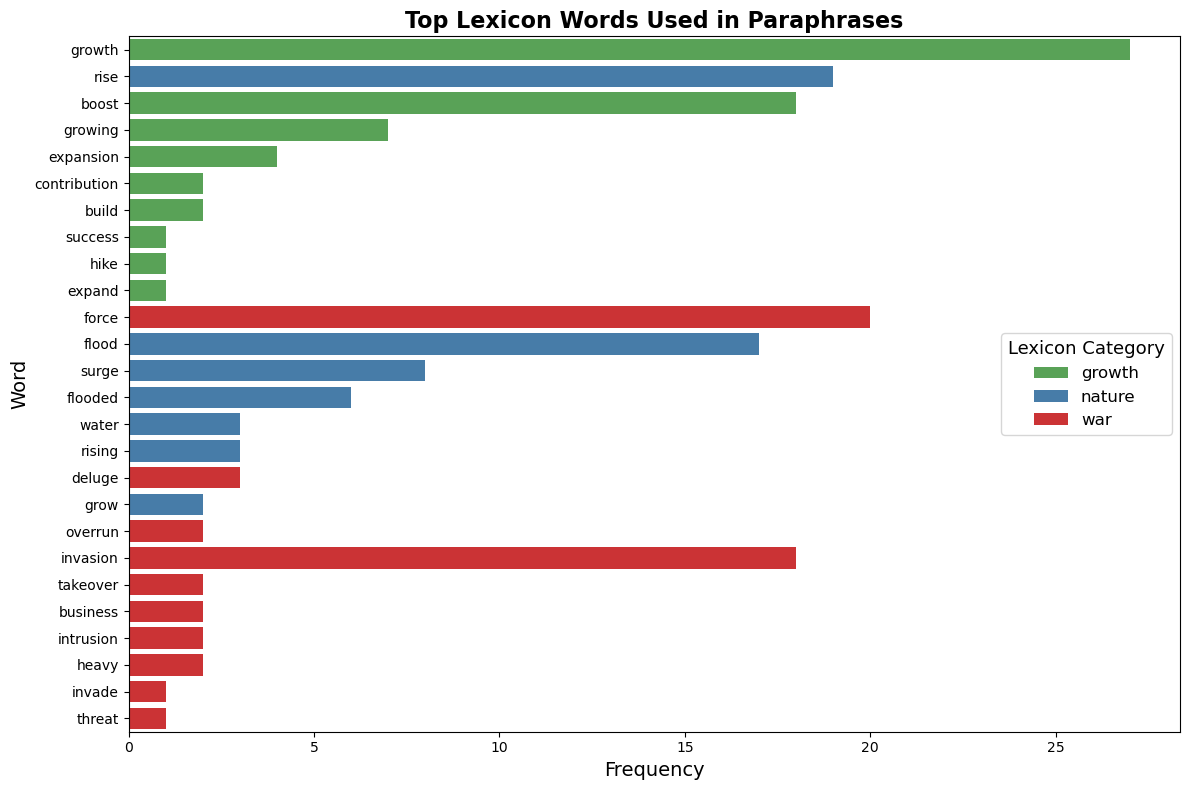

In [272]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get top 10 from each category
top_words_df = (
    lexicon_words_df
    .groupby("category")
    .apply(lambda g: g.nlargest(10, "count"))
    .reset_index(drop=True)
)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_words_df,
    x="count", y="word", hue="category",
    dodge=False, palette={"war": "#e41a1c", "nature": "#377eb8", "growth": "#4daf4a"}
)
plt.title("Top Lexicon Words Used in Paraphrases", fontsize=16, weight='bold')
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Word", fontsize=14)
plt.legend(title="Lexicon Category", fontsize=12, title_fontsize=13)
plt.tight_layout()
plt.show()

In [273]:
import statsmodels.formula.api as smf

# WAR-themed language
model_war = smf.ols("prop_war_filtered ~ C(condition) * C(politicalView)", data=df).fit()
print("\n=== WAR FRAME MODEL ===")
print(model_war.summary())

# NATURE-themed language
model_nature = smf.ols("prop_nature_filtered ~ C(condition) * C(politicalView)", data=df).fit()
print("\n=== NATURE FRAME MODEL ===")
print(model_nature.summary())

# GROWTH-themed language
model_growth = smf.ols("prop_growth_filtered ~ C(condition) * C(politicalView)", data=df).fit()
print("\n=== GROWTH FRAME MODEL ===")
print(model_growth.summary())


=== WAR FRAME MODEL ===
                            OLS Regression Results                            
Dep. Variable:      prop_war_filtered   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2.862
Date:                Wed, 02 Apr 2025   Prob (F-statistic):            0.00107
Time:                        23:49:25   Log-Likelihood:                 715.29
No. Observations:                 867   AIC:                            -1407.
Df Residuals:                     855   BIC:                            -1349.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

In [275]:
from collections import Counter

# Flatten and count all words across paraphrases
all_words = [word for tokens in df["paraphrase_tokens"] for word in tokens]
word_counts = Counter(all_words)

# Select only words from our lexicons
combined_lexicon = set(war_lexicon + nature_lexicon + growth_lexicon)
lexicon_word_counts = {word: count for word, count in word_counts.items() if word in combined_lexicon}

# Convert to DataFrame and sort
lexicon_word_df = pd.DataFrame.from_dict(lexicon_word_counts, orient='index', columns=['count'])
lexicon_word_df = lexicon_word_df.sort_values(by='count', ascending=False).reset_index()
lexicon_word_df.columns = ['word', 'count']

In [288]:
import re

# STEP 1: Tokenize openQ
df["openQ_tokens"] = (
    df["openQ"].astype(str)
    .str.lower()
    .apply(lambda x: re.findall(r"\b\w+\b", x))
)

# STEP 2: Remove original passage words
df["openQ_non_passage_tokens"] = df["openQ_tokens"].apply(lambda tokens: [w for w in tokens if w not in passage_tokens])
df["n_openQ_non_passage"] = df["openQ_non_passage_tokens"].apply(len)

# STEP 3: Lexicon match counts (filtered)
df["openQ_war_matches_filtered"] = df["openQ_non_passage_tokens"].apply(lambda x: count_matches_filtered(x, war_expanded))
df["openQ_nature_matches_filtered"] = df["openQ_non_passage_tokens"].apply(lambda x: count_matches_filtered(x, nature_expanded))
df["openQ_growth_matches_filtered"] = df["openQ_non_passage_tokens"].apply(lambda x: count_matches_filtered(x, growth_expanded))

# STEP 4: Normalize by non-passage token count
df["openQ_prop_war"] = df["openQ_war_matches_filtered"] / df["n_openQ_non_passage"]
df["openQ_prop_nature"] = df["openQ_nature_matches_filtered"] / df["n_openQ_non_passage"]
df["openQ_prop_growth"] = df["openQ_growth_matches_filtered"] / df["n_openQ_non_passage"]


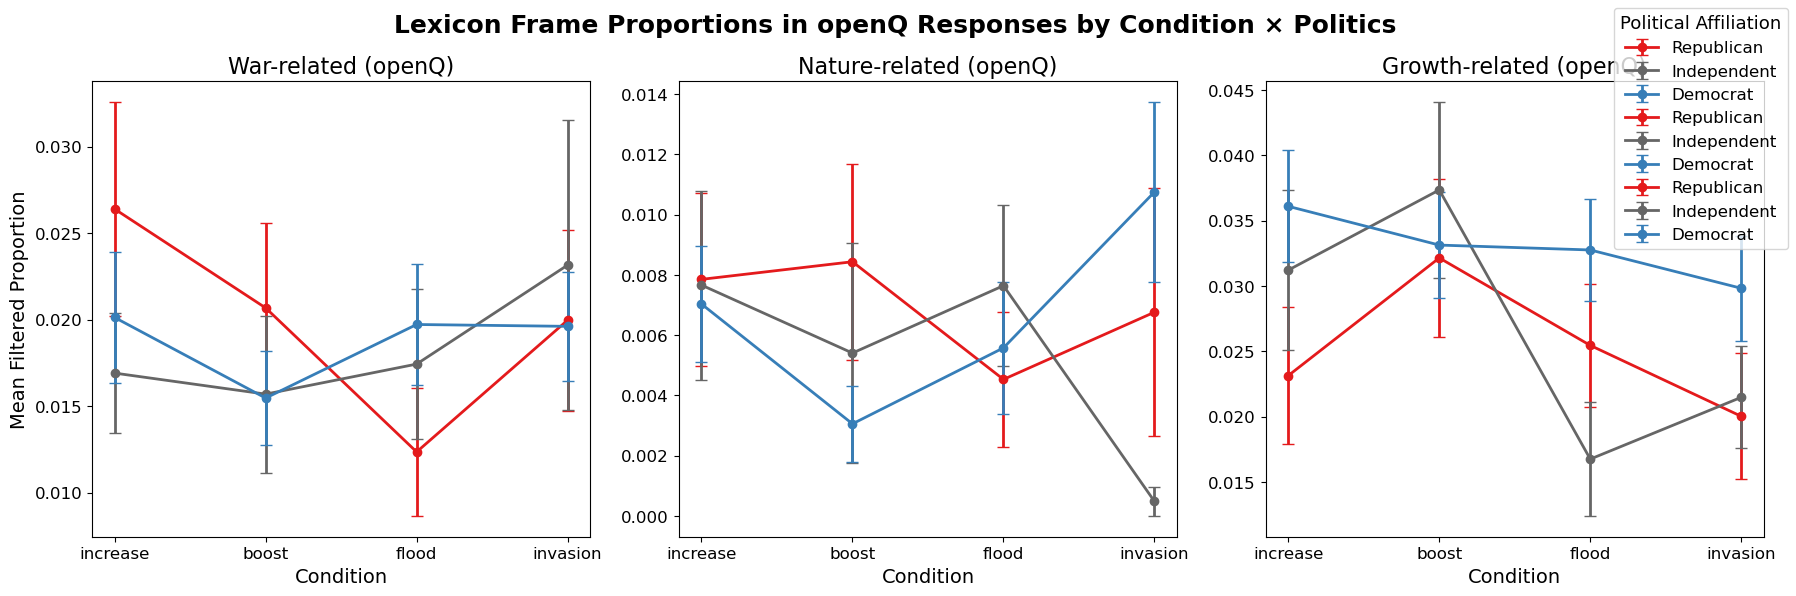

In [289]:
import numpy as np
import matplotlib.pyplot as plt

# Group and summarize openQ match data
summary_openq = (
    df
    .groupby(["condition", "politicalView"], observed=True)
    .agg(
        n=("openQ", "count"),
        mean_war=("openQ_prop_war", "mean"),
        se_war=("openQ_prop_war", lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
        mean_nature=("openQ_prop_nature", "mean"),
        se_nature=("openQ_prop_nature", lambda x: np.std(x, ddof=1) / np.sqrt(len(x))),
        mean_growth=("openQ_prop_growth", "mean"),
        se_growth=("openQ_prop_growth", lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
    )
    .reset_index()
)

# Plotting setup
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

metrics = [
    ("mean_war", "se_war", "War-related (openQ)"),
    ("mean_nature", "se_nature", "Nature-related (openQ)"),
    ("mean_growth", "se_growth", "Growth-related (openQ)")
]

for i, (mean_col, se_col, title) in enumerate(metrics):
    ax = axes[i]
    for party in politics:
        subset = summary_openq[summary_openq["politicalView"] == party]
        x = np.arange(len(conditions))
        means = [subset[subset["condition"] == cond][mean_col].values[0] if cond in subset["condition"].values else np.nan for cond in conditions]
        errors = [subset[subset["condition"] == cond][se_col].values[0] if cond in subset["condition"].values else np.nan for cond in conditions]
        ax.errorbar(
            x, means, yerr=[1.00 * e for e in errors],
            label=party, color=palette[party], marker='o',
            linewidth=2, capsize=4
        )
    ax.set_xticks(x)
    ax.set_xticklabels(conditions, fontsize=12)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Condition", fontsize=14)
    if i == 0:
        ax.set_ylabel("Mean Filtered Proportion", fontsize=14)
    ax.tick_params(labelsize=12)

fig.suptitle("Lexicon Frame Proportions in openQ Responses by Condition × Politics", fontsize=18, weight='bold')
fig.legend(title="Political Affiliation", fontsize=12, title_fontsize=13, loc="upper right")
plt.tight_layout()
plt.show()


In [293]:
import statsmodels.formula.api as smf

model_war = smf.ols("openQ_prop_war ~ C(condition) * C(politicalView)", data=df).fit()
model_nature = smf.ols("openQ_prop_nature ~ C(condition) * C(politicalView)", data=df).fit()
model_growth = smf.ols("openQ_prop_growth ~ C(condition) * C(politicalView)", data=df).fit()

print(model_war.summary())
print(model_nature.summary())
print(model_growth.summary())

                            OLS Regression Results                            
Dep. Variable:         openQ_prop_war   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.6150
Date:                Thu, 03 Apr 2025   Prob (F-statistic):              0.817
Time:                        00:10:52   Log-Likelihood:                 1650.5
No. Observations:                 875   AIC:                            -3277.
Df Residuals:                     863   BIC:                            -3220.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

**Does metaphorical framing (e.g., invasion, flood, boost) in the original passage shape how participants later describe immigration — in either their recall (paraphrases) or opinion-based responses (openQ)?**

**Paraphrases Show Strong Framing Effects**
Participants’ paraphrases — where they recalled or rephrased the original passage — were strongly shaped by the metaphor they were exposed to.

Invasion Frame ➤ More War Language

Participants in the invasion condition used significantly more war-related words (e.g., "attack", "enemy", "threat").

p = .010, effect retained even when controlling for political view.

Flood Frame ➤ More Nature/Disaster Language

Participants in the flood condition also used more nature-based words (e.g., "wave", "surge"), but this was only marginally significant.

Stronger increases were seen among Democrats.

Boost Frame ➤ More Growth/Positive Language

The boost condition led to more usage of growth-related terms (e.g., "opportunity", "business"), particularly among Republicans and Independents.

Statistically significant: p = .034

🔍 Interpretation:
When people retell what they read, they appear to mirror the metaphor they were given — reinforcing its frame in their language.

** openQ Responses: Framing Influence Weaker **
When asked to express their own opinions about the effects of immigration (openQ), participants' language was less sensitive to the metaphor.

War-related language was not significantly higher in the invasion condition (p = .38).

Nature/disaster language did not increase in the flood condition.

Growth-related language was somewhat higher among Democrats (p = .058), but framing itself had no consistent effect.

Interpretation:
While people mimic metaphors when recalling the stimulus, they do not consistently carry those metaphors into their open-ended policy opinions — possibly due to:

More deliberative reasoning in opinion responses

Use of personal beliefs overriding the frame

Lexicon mismatch (e.g., people may agree with a frame without using its language)

**Conclusion**
🧠 Memory-based retellings (paraphrases) are highly frame-sensitive: people unconsciously echo the metaphor.

💬 Open-ended evaluations (openQ) show weaker effects, suggesting framing has more impact on memory than belief — or that people resist metaphor adoption in their own voice.

In [297]:
summary_neutral = (
    df_neutral
    .groupby("politicalView", observed=True)
    .agg(
        n=("paraphrase", "count"),
        war_paraphrase_mean=("prop_war_filtered", "mean"),
        war_openQ_mean=("openQ_prop_war", "mean"),
        nature_paraphrase_mean=("prop_nature_filtered", "mean"),
        nature_openQ_mean=("openQ_prop_nature", "mean")
    )
    .reset_index()
)
print(summary_neutral)

  politicalView    n  war_paraphrase_mean  war_openQ_mean  \
0    Republican   55             0.008488        0.026393   
1   Independent   61             0.003279        0.016909   
2      Democrat  105             0.015686        0.020123   

   nature_paraphrase_mean  nature_openQ_mean  
0                0.002315           0.007853  
1                0.014208           0.007662  
2                0.048529           0.007035  


In [298]:
import statsmodels.formula.api as smf

# OpenQ war frame usage
model_war = smf.ols("openQ_prop_war ~ C(politicalView)", data=df_neutral).fit()
model_flood = smf.ols("openQ_prop_nature ~ C(politicalView)", data=df_neutral).fit()
print(model_war.summary())
print(model_flood.summary())

                            OLS Regression Results                            
Dep. Variable:         openQ_prop_war   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9323
Date:                Thu, 03 Apr 2025   Prob (F-statistic):              0.395
Time:                        00:36:30   Log-Likelihood:                 410.63
No. Observations:                 221   AIC:                            -815.3
Df Residuals:                     218   BIC:                            -805.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Test whether Republicans (vs. Democrats) exposed to neutral framing (e.g., increase) are more likely to use invasion/flood-related language (above). Doesn't seem like it.

In [395]:
from sentence_transformers import SentenceTransformer, util
import torch
import pandas as pd

# Define improved frame prompts with clearer semantic and emotional context
frame_prompts = {
    "Labor/economic contribution": "Immigrants contribute to the economy by filling labor shortages and supporting local businesses.",
    "Business creation / entrepreneurship": "Immigrants start businesses, create jobs, and help the local economy grow.",
    "Cultural enrichment / diversity": "Immigrants bring cultural diversity, enriching the community with new traditions and perspectives.",
    "Demographic growth / population support": "Immigrants support population growth, helping sustain schools, services, and economic vitality.",
    "Strain on resources": "Immigrants strain local resources like healthcare, housing, and public services.",
    "Wage depression / job competition": "Immigrants take jobs from locals and lower wages by increasing labor competition.",
    "Crime and security concerns": "Immigrants increase crime rates and raise concerns about safety and law enforcement.",
    "Cultural displacement or conflict": "Immigrants cause cultural clashes or dilute the existing identity of the community."
}

# Load sentiment-aware embedding model (same one used before for consistency)
model = SentenceTransformer("all-MiniLM-L6-v2")

# Embed frame prompts with richer context
frame_labels = list(frame_prompts.keys())
frame_texts = list(frame_prompts.values())
frame_embeddings = model.encode(frame_texts, convert_to_tensor=True)

# Store for later reuse in ensemble/similarity checking
frame_embeddings, frame_labels


(tensor([[ 0.0692, -0.0418, -0.0004,  ...,  0.1078,  0.1253, -0.0262],
         [ 0.0729, -0.0378,  0.0225,  ...,  0.0800,  0.1407,  0.0047],
         [ 0.0862,  0.0340, -0.0519,  ...,  0.0981,  0.0816, -0.0312],
         ...,
         [ 0.0379, -0.0109,  0.0450,  ...,  0.0780,  0.1512,  0.0364],
         [ 0.0710, -0.0019, -0.0551,  ...,  0.0612,  0.1046, -0.0295],
         [ 0.0930,  0.0697, -0.0108,  ...,  0.1239,  0.1038, -0.0663]],
        device='mps:0'),
 ['Labor/economic contribution',
  'Business creation / entrepreneurship',
  'Cultural enrichment / diversity',
  'Demographic growth / population support',
  'Strain on resources',
  'Wage depression / job competition',
  'Crime and security concerns',
  'Cultural displacement or conflict'])

In [649]:
import pickle
from tqdm import tqdm
import numpy as np
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
import torch
import pandas as pd

# Load or run the zero-shot classifier
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Check if the cached results exist
try:
    with open('zero_shot_results.pkl', 'rb') as f:
        zero_shot_results = pickle.load(f)
    print("Loaded cached zero-shot results.")
except FileNotFoundError:
    # If no cache is found, run the zero-shot classification and save the results
    openq_texts = df["openQ"].astype(str).fillna("").str.strip().tolist()
    zero_shot_results = [classifier(text, frame_labels) for text in openq_texts]
    with open('zero_shot_results.pkl', 'wb') as f:
        pickle.dump(zero_shot_results, f)
    print("Computed and cached zero-shot results.")

# Step 1: Re-embed OpenQ responses
model = SentenceTransformer("all-MiniLM-L6-v2")
openq_embeddings = model.encode(openq_texts, convert_to_tensor=True, show_progress_bar=True)

# Step 2: Use RoBERTa categorical sentiment scores from 'roberta_sentiment' column in the dataframe
sentiment_categories = df['roberta_sentiment'].values  # Get sentiment labels (negative, neutral, positive)

# Step 3: Adjust frame weights based on sentiment (only bias for positive/negative, neutral has no effect)
frame_weights = torch.zeros(len(frame_labels))  # Initialize weights to 0 for all frames

# Increase weight for positive sentiment, decrease for negative
for i, sentiment in enumerate(sentiment_categories):
    if sentiment == 'positive':
        frame_weights += 1  # Increase weight for positive sentiment
    elif sentiment == 'negative':
        frame_weights -= 1  # Decrease weight for negative sentiment
    # If sentiment is neutral, no change to frame_weights (it remains 0)

frame_weights = frame_weights.unsqueeze(0)  # shape: (1, n_frames)

# Step 4: Compute ensemble similarity (semantic + sentiment)
cos_sim = util.cos_sim(openq_embeddings, frame_embeddings)  # shape: (n_openq, n_frames)

# Step 5: Ensure all tensors are on the same device
device = openq_embeddings.device
frame_embeddings = frame_embeddings.to(device)
sentiment_tensor = sentiment_tensor.to(device)
frame_weights = frame_weights.to(device)
cos_sim = cos_sim.to(device)

# Step 6: Compute sentiment-adjusted similarity
sentiment_adjustment = sentiment_tensor * frame_weights  # Apply sentiment weights to frames
# ensemble_sim = cos_sim + 0.2 * sentiment_adjustment  # 0.6 is the tunable weight for sentiment influence
ensemble_sim = cos_sim

# Normalize ensemble_sim to be between 0 and 1 (or adjust to other scale as needed)
min_sim = ensemble_sim.min()
max_sim = ensemble_sim.max()

# Rescale to the [0, 1] range
ensemble_sim_normalized = (ensemble_sim - min_sim) / (max_sim - min_sim)

# Step 7: Get top-2 frames and apply thresholds
frame_presence_thresh = torch.zeros_like(ensemble_sim_normalized)

for i in range(ensemble_sim_normalized.shape[0]):
    row = ensemble_sim_normalized[i]
    
    # Get top-2 frame similarity scores
    top_scores, top_indices = torch.topk(row, k=2, dim=0)
    
    # Use cached LLM results (zero_shot_results)
    result = zero_shot_results[i]
    predicted_frame = result["labels"][0]  # top predicted frame
    predicted_score = result["scores"][0]

    # Apply threshold logic: allow top-2 frames if the score is sufficiently high
    if predicted_score > 0.3:  # Threshold for inclusion
        top_idx = frame_labels.index(predicted_frame)  # Get frame index
        frame_presence_thresh[i, top_idx] = 1
    
    # Apply detection for top-2 frames based on similarity scores
    for idx in top_indices:
        if row[idx] > 0.4:  # Example: Apply a threshold for the second-highest frame
            frame_presence_thresh[i, idx] = 1

# Step 8: Convert to pandas DataFrame
df_topk = pd.DataFrame(frame_presence_thresh.cpu().numpy(), columns=frame_labels)
df_topk.index = df.index  # align index

# Drop old frame columns to avoid contamination
df = df.drop(columns=[col for col in df.columns if col in frame_labels], errors="ignore")

# Step 9: Merge the frame presence back into the original DataFrame
df = pd.concat([df, df_topk], axis=1)

Device set to use mps:0


Loaded cached zero-shot results.


Batches:   0%|          | 0/28 [00:00<?, ?it/s]

In [650]:
# This is the important bit that removes duplicated column names
df_clean = df.loc[:, ~df.columns.duplicated()].copy()

# Re-define frame_labels to ensure they match what's in the cleaned df
frame_labels = [
    "Labor/economic contribution",
    "Business creation / entrepreneurship",
    "Cultural enrichment / diversity",
    "Demographic growth / population support",
    "Strain on resources",
    "Wage depression / job competition",
    "Crime and security concerns",
    "Cultural displacement or conflict"
]

# Compute mean and standard error per condition × frame (only for detected frames)
summary_rows = []
for frame in frame_labels:
    for condition, group in df_clean.groupby("condition"):  # Group by 'condition'
        # Only consider frames that were detected (based on frame_presence_thresh)
        if frame in df_clean.columns and group[frame].sum() > 0:  # If the frame was detected
            frame_values = group[frame].dropna()

            # Only compute statistics for the frame if there are values to compute
            if not frame_values.empty:
                mean = frame_values.mean()
                se = frame_values.std(ddof=1) / np.sqrt(len(frame_values)) if len(frame_values) > 1 else np.nan

                summary_rows.append({
                    "condition": condition,  # Group by condition
                    "frame": frame,
                    "mean": mean,
                    "se": se
                })

# Convert the summary into a DataFrame
summary_pivot = pd.DataFrame(summary_rows)

In [651]:
# Compute mean and standard error per politicalView × frame (only for detected frames)
summary_rows_politics = []
for frame in frame_labels:
    for politicalView, group in df_clean.groupby("politicalView"):  # Group by 'politicalView'
        # Get the indices of the group rows to access the frame_presence_thresh
        group_indices = group.index
        
        # Only consider frames that were detected for the current politicalView group
        if frame in df_clean.columns and (frame_presence_thresh[group_indices].sum() > 0):  # If the frame was detected
            frame_values = group[frame].dropna()

            # Only compute statistics for the frame if there are values to compute
            if not frame_values.empty:
                mean = frame_values.mean()
                se = frame_values.std(ddof=1) / np.sqrt(len(frame_values)) if len(frame_values) > 1 else np.nan

                summary_rows_politics.append({
                    "politicalView": politicalView,  # Group by politicalView
                    "frame": frame,
                    "mean": mean,
                    "se": se
                })

# Convert the summary into a DataFrame
summary_pivot_politics = pd.DataFrame(summary_rows_politics)

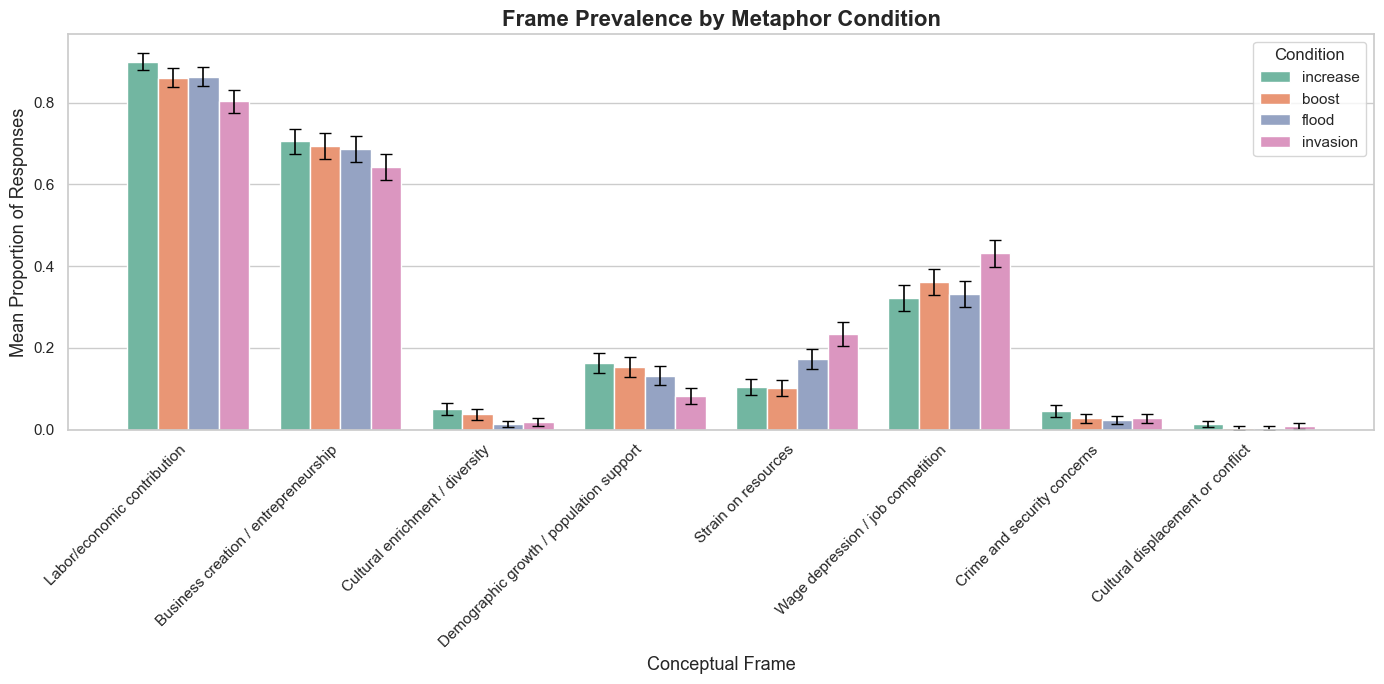

In [652]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare plot
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

# Barplot: frame × mean, grouped by condition
ax = sns.barplot(
    data=summary_pivot,  # Assuming summary_pivot contains the necessary data
    x="frame",
    y="mean",
    hue="condition",  # Grouping by 'condition' as you originally wanted
    palette="Set2",
    dodge=True
)

# Add error bars manually
# Get the unique orderings used in barplot
frame_order = summary_pivot["frame"].unique().tolist()
condition_order = summary_pivot["condition"].unique().tolist()

# Determine bar width & offsets
bar_width = 0.8 / len(condition_order)  # divide total width among hue groups

for i, row in summary_pivot.iterrows():
    frame_index = frame_order.index(row["frame"])
    hue_index = condition_order.index(row["condition"])

    # Centered x offset for each hue
    x = frame_index - 0.4 + bar_width / 2 + hue_index * bar_width

    ax.errorbar(
        x, row["mean"], yerr=row["se"],
        fmt='none', c='black', capsize=4, linewidth=1.2
    )

# Final touches
plt.xticks(ticks=range(len(frame_order)), labels=frame_order, rotation=45, ha="right")
plt.title("Frame Prevalence by Metaphor Condition", fontsize=16, weight="bold")
plt.xlabel("Conceptual Frame", fontsize=13)
plt.ylabel("Mean Proportion of Responses", fontsize=13)
plt.legend(title="Condition", title_fontsize=12, fontsize=11)
plt.tight_layout()
plt.show()

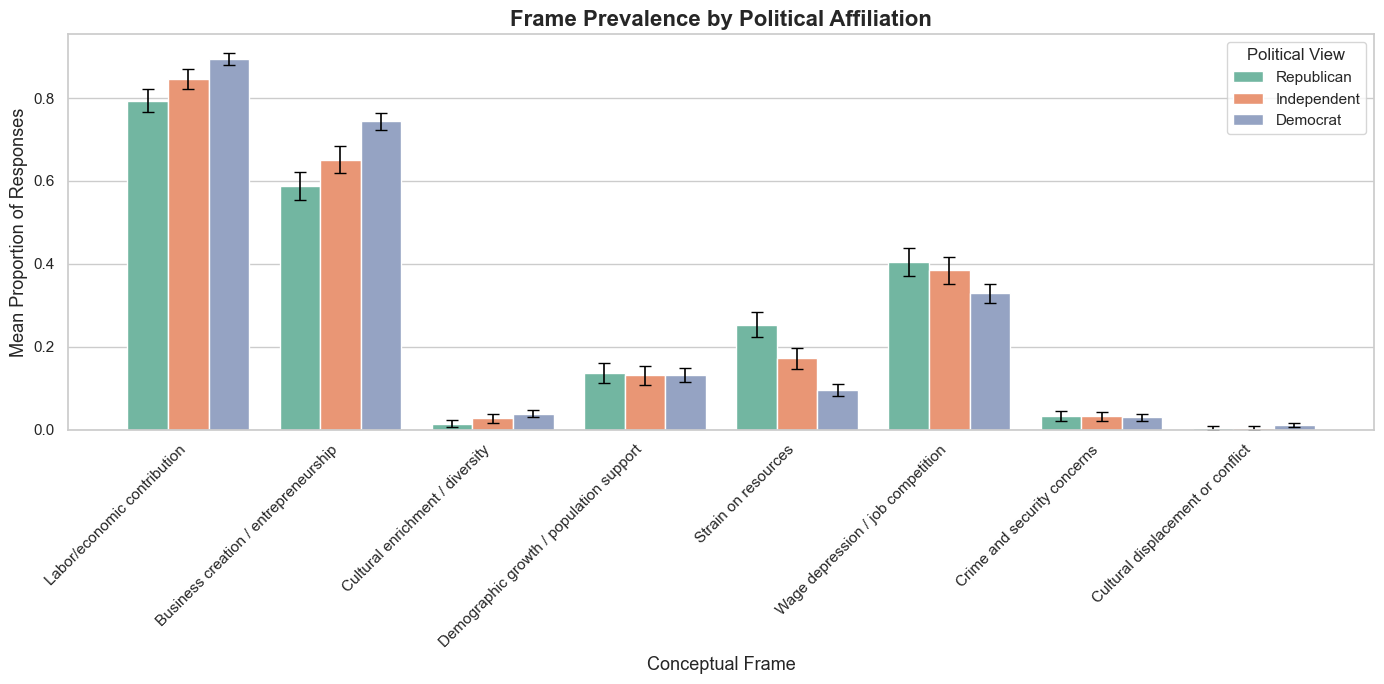

In [653]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare plot
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

# Barplot: frame × mean, grouped by politicalView
ax = sns.barplot(
    data=summary_pivot_politics,  # Using the updated summary for politicalView
    x="frame",
    y="mean",
    hue="politicalView",  # Grouping by politicalView
    palette="Set2",
    dodge=True
)

# Add error bars manually
# Get the unique orderings used in barplot
frame_order = summary_pivot_politics["frame"].unique().tolist()
politics_order = summary_pivot_politics["politicalView"].unique().tolist()

# Determine bar width & offsets
bar_width = 0.8 / len(politics_order)  # divide total width among hue groups

for i, row in summary_pivot_politics.iterrows():
    frame_index = frame_order.index(row["frame"])
    hue_index = politics_order.index(row["politicalView"])

    # Centered x offset for each hue
    x = frame_index - 0.4 + bar_width / 2 + hue_index * bar_width

    ax.errorbar(
        x, row["mean"], yerr=row["se"],
        fmt='none', c='black', capsize=4, linewidth=1.2
    )

# Final touches
plt.xticks(ticks=range(len(frame_order)), labels=frame_order, rotation=45, ha="right")
plt.title("Frame Prevalence by Political Affiliation", fontsize=16, weight="bold")
plt.xlabel("Conceptual Frame", fontsize=13)
plt.ylabel("Mean Proportion of Responses", fontsize=13)
plt.legend(title="Political View", title_fontsize=12, fontsize=11)
plt.tight_layout()
plt.show()

In [654]:
# Remove duplicated columns in case any frame columns were duplicated (important for clean processing)
df = df.loc[:, ~df.columns.duplicated()].copy()

# For a single example (change the index as needed)
i = 300  # any row index
print("OpenQ:", df.loc[i, "openQ"])
print("Ensemble similarities:")
for j, frame in enumerate(frame_labels):
    print(f"  {frame}: {ensemble_sim[i][j].item():.3f}")

print("\nFrames detected:")
frames_printed = set()  # To track which frames have been printed

# Check for frame presence using the frame_presence_thresh matrix (updated with the threshold logic)
for j, frame in enumerate(frame_labels):
    # Check if the frame is detected using the stricter threshold logic
    if frame_presence_thresh[i, j] == 1 and frame not in frames_printed:  # Only check if the frame is detected and hasn't been printed
        print(f"✅ {frame}")
        frames_printed.add(frame)  # Add to the set of printed frames

    # Optionally, if you want to print frames that passed the stricter threshold
    # If you have the top two frames or use a different approach:
    result = zero_shot_results[i]
    labels = result["labels"]
    scores = result["scores"]

    # Check if the frame is in the top two or has a high score
    top_frames = [labels[k] for k in range(len(scores)) if scores[k] > 0.4]
    if frame in top_frames and frame not in frames_printed:  # Only print if it's a top frame and hasn't been printed
        print(f"✅ {frame} (top frame with score > 0.4)")
        frames_printed.add(frame)  # Add to the set of printed frames

OpenQ: I believe it has taken jobs away from actual native citizens. It also increases the chance for illegal immigrants. 
Ensemble similarities:
  Labor/economic contribution: 0.460
  Business creation / entrepreneurship: 0.488
  Cultural enrichment / diversity: 0.360
  Demographic growth / population support: 0.436
  Strain on resources: 0.445
  Wage depression / job competition: 0.557
  Crime and security concerns: 0.473
  Cultural displacement or conflict: 0.393

Frames detected:
✅ Business creation / entrepreneurship
✅ Strain on resources
✅ Wage depression / job competition
